<a href="https://www.kaggle.com/code/emrekaany/preprocessing-object-speed-by-yolov8-deepsort?scriptVersionId=236110294" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# 📘 Nexar Preprocessing for YOLOv8 + DeepSORT

**You can see how the method correctly finds out objects and their speed. Download the outputs and see it yourself!**

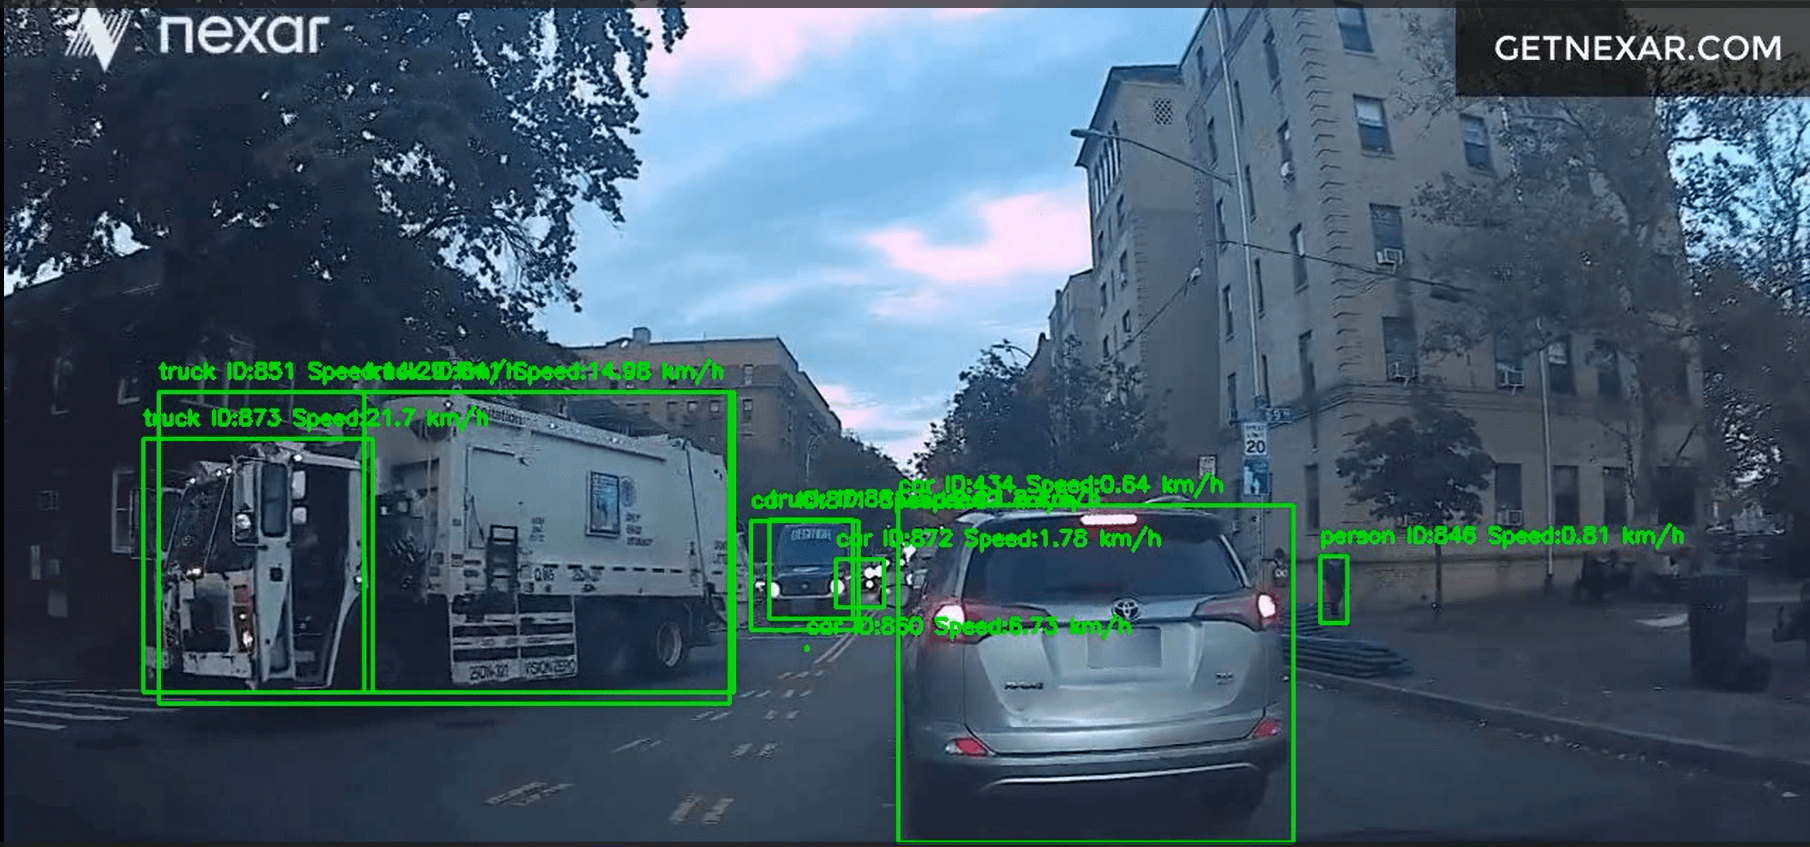

This notebook demonstrates a **data preprocessing pipeline** for training object detection and tracking models using **YOLOv8** and **DeepSORT**.  
We focus on preparing input data for a robust pipeline, suitable for vehicle tracking from dashcam footage.

---

##  Techniques Used

###  YOLOv8
- State-of-the-art real-time object detection model.
- Fast and lightweight for vehicle detection.

###  DeepSORT
- Multi-object tracking algorithm that associates detections across frames.
- Uses both motion and appearance cues.

---

##  Goals of This Notebook

- Load and prepare Nexar dashcam videos.
- Use YOLOv8 to extract object detections.
- Prepare detection results in DeepSORT-compatible format.
- Save results for downstream training or analysis.

---

**Note:** Code blocks include explanations, and some cells include notes on potential improvements or simplifications.


In [ ]:
# ✅ Install YOLOv8 from Ultralytics
!pip install ultralytics --quiet


In [ ]:
!pip install deep-sort-realtime --quiet


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


In [ ]:

# import csv files
df = pd.read_csv('/kaggle/input/nexar-collision-prediction/train.csv')
df_test = pd.read_csv('/kaggle/input/nexar-collision-prediction/test.csv')

# convert all id column to 5 digits
df["id"] = df["id"].astype(str).str.zfill(5)
df_test["id"] = df_test["id"].astype(str).str.zfill(5)

# video file paths
train_dir = "/kaggle/input/nexar-collision-prediction/train/"
test_dir = "/kaggle/input/nexar-collision-prediction/test/"

# import video files according to our listing
df ['train_videos'] = df["id"] + ".mp4"
df_test ['test_videos']  = df_test["id"] + ".mp4"

print(f"Örnek Train ID: {df['id'].head()}")
print(f"Örnek Test ID: {df_test['id'].head()}")

print(f"Toplam Train Videosu: {len(df ['train_videos'])}")
print(f"Toplam Test Videosu: {len(df_test ['test_videos'])}")


In [ ]:
import cv2
import torch
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# **CONFIGURATION**  
OUTPUT_DIR = "/kaggle/working/output_videos"  # Directory to save output videos
LOG_DIR = "/kaggle/working/tracking_logs"  # Directory to save tracking logs
EXCEL_PATH = "/kaggle/working/tracking_results.xlsx"  # Final results in Excel
# 🧠 Load the YOLOv8 object detection model
MODEL_PATH = "yolov8n.pt"  # Default YOLOv8 model

# Ensure directories exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# 🧠 Load the YOLOv8 object detection model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLO(MODEL_PATH).to(device)

# **Initialize DeepSORT Tracker**
tracker = DeepSort(max_age=30, n_init=3, nn_budget=100)

# **Object Categories to Track**
TARGET_CLASSES = {
    0: "person",
    1: "bicycle",
    2: "car",
    3: "motorcycle",
    5: "bus",
    7: "truck"
}  # COCO Class IDs: persons, vehicles, bicycles, etc.

# **Function to Estimate Speed**
def estimate_speed(prev_position, current_position, fps):
    """Estimate speed using pixel displacement over time."""
    if prev_position is None:
        return 0  # No previous data
    dx = current_position[0] - prev_position[0]
    dy = current_position[1] - prev_position[1]
    displacement = np.sqrt(dx**2 + dy**2)  # Euclidean distance
    pixels_per_second = displacement * fps
    speed_kmh = (pixels_per_second / 30) * 3.6  # Convert to km/h
    return round(speed_kmh, 2)

# **Function to Process a Single Video**
def process_video(video_name, train_dir):
    video_path = os.path.join(train_dir, video_name)
    video_id = os.path.basename(video_name).split(".")[0]
    output_path = os.path.join(OUTPUT_DIR, f"output_{video_id}.mp4")

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    tracking_data = []
    object_speeds = {}

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # **YOLO Object Detection**
        results = model(frame)
        detections = []

        for result in results:
            for box in result.boxes.data:
                x1, y1, x2, y2, conf, cls = box.tolist()
                cls = int(cls)
                if cls in TARGET_CLASSES:  # Filter target classes
                    detections.append(([x1, y1, x2 - x1, y2 - y1], conf, cls))

        # **DeepSORT Object Tracking**
        tracked_objects = tracker.update_tracks(detections, frame=frame)

        for track in tracked_objects:
            if not track.is_confirmed():
                continue

            track_id = track.track_id
            x1, y1, w, h = track.to_tlwh()
            x2, y2 = x1 + w, y1 + h
            obj_cls = track.det_class
            obj_name = TARGET_CLASSES.get(obj_cls, "unknown")

            # **Estimate Speed**
            prev_position = object_speeds.get(track_id)
            current_position = ((x1 + x2) / 2, (y1 + y2) / 2)
            speed = estimate_speed(prev_position, current_position, fps)
            object_speeds[track_id] = current_position

            # **Draw Bounding Box and ID**
            color = (0, 255, 0)
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            label = f"{obj_name} ID:{track_id} Speed:{speed} km/h"
            cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # **Save Tracking Data**
            tracking_data.append([video_id, track_id, obj_name, x1, y1, x2, y2, speed])

        out.write(frame)

    cap.release()
    out.release()

    print(f"✅ Processed: {video_id} → {output_path}")

    # **Return DataFrame**
    return pd.DataFrame(tracking_data, columns=["video_id", "track_id", "object", "x1", "y1", "x2", "y2", "speed_kmh"])

# **Process All Videos in `df['train_videos']` and Save to a Single DataFrame**
def process_all_videos(df, train_dir):
    video_list = df["train_videos"].tolist()
    print(f"🔄 Processing {len(video_list)} videos...")

    all_results = pd.DataFrame(columns=["video_id", "track_id", "object", "x1", "y1", "x2", "y2", "speed_kmh"])

    for video_name in video_list:
        result_df = process_video(video_name, train_dir)
        all_results = pd.concat([all_results, result_df], ignore_index=True)

    return all_results


# **Process Videos and Collect Data**
tracking_results = process_all_videos(df.iloc[0:2], train_dir)

# **Save as Excel File**
excel_path = "/kaggle/working/tracking_results.xlsx"
tracking_results.to_csv(excel_path, index=False)

print(f"📂 Tracking results saved to: {excel_path}")

